In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.ensemble import RandomForestRegressor

In [75]:
def funcArmonica(x, a, b):
    return a * np.sin(b*2*np.pi*x)

In [76]:
def funcAmortiguada(x, a, b, c):
    return a * np.sin(b*2*np.pi*x) *np.exp(-c*x)

In [65]:
font = {'family' : 'normal',
        'weight' : 'semibold',
        'size'   : 10}

plt.matplotlib.rc('font', **font)

In [77]:
n_periodo = 250
t_final = 1
amp = 0.10
freq = 5.0 # Hz
N = int(n_periodo*t_final*freq)
t_data = np.linspace(0, t_final, N)
gamma = 0.05
y_sr = funcAmortiguada(t_data, amp, freq, gamma)
y_data = y_sr + 0.0025*np.random.normal(size = N)

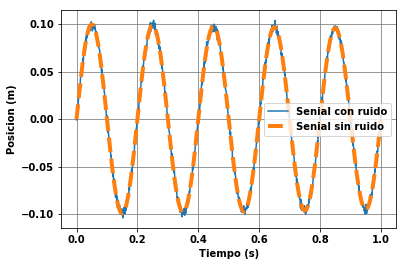

In [81]:
#plt.figure(figsize=(12,8))
plt.plot(t_data,y_data, label = 'Senial con ruido')
plt.plot(t_data,y_sr, '--', lw = 4, label = 'Senial sin ruido')
plt.grid(color = 'gray')
plt.legend()
plt.xlabel('Tiempo (s)', fontdict = font)
plt.ylabel('Posicion (m)', fontdict = font)
plt.savefig('OA_senial_con_y_sin_ruido', dpi = 500)
plt.show()

In [6]:
params, params_covariance = optimize.curve_fit(funcArmonica, t_data[0:2*n_periodo], y_data[0:2*n_periodo], bounds=(0, [1, 10]))
print(params)
print(params_covariance)

[0.09893228 4.9997459 ]
[[2.57335220e-08 1.22563548e-08]
 [1.22563548e-08 1.23869325e-06]]


In [7]:
error = np.sqrt(np.sum((funcArmonica(t_data[2*n_periodo:], params[0], params[1]) - y_sr[2*n_periodo:])**2))
error = error/(N - 2*n_periodo)
print(round(error,6))

6.5e-05


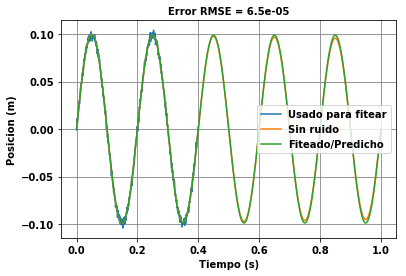

In [82]:
#plt.figure(figsize=(12,8))
plt.plot(t_data[0:2*n_periodo],y_data[0:2*n_periodo], label = 'Usado para fitear')
plt.plot(t_data, y_sr,label='Sin ruido')
plt.plot(t_data, funcArmonica(t_data, params[0], params[1]),label='Fiteado/Predicho')
plt.title('Error RMSE = ' + str(round(error,6)), fontdict = font)
plt.grid(color = 'gray')
plt.xlabel('Tiempo (s)', fontdict = font)
plt.ylabel('Posicion (m)', fontdict = font)
plt.legend()

plt.savefig('OA_ajuste', dpi = 500)
plt.show()

## Medición Larga

In [9]:
t_final = 80
N = int(n_periodo*t_final*freq)
t_data = np.linspace(0, t_final, N)
y_sr = funcAmortiguada(t_data, amp, freq, gamma)
y_data = y_sr + 0.0025*np.random.normal(size = N)

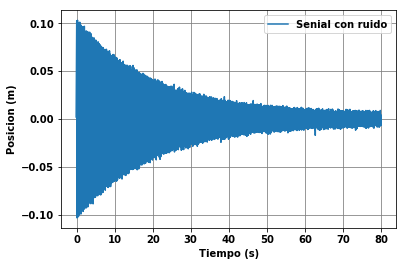

In [70]:
#plt.figure(figsize=(15,12))

plt.plot(t_data,y_data, label = 'Senial con ruido')
#plt.plot(t_data,y_sr, '--', lw = 4, label = 'Senial sin ruido')
plt.grid(color = 'gray')
#plt.grid()
plt.legend()
plt.xlabel('Tiempo (s)', fontdict = font)
plt.ylabel('Posicion (m)', fontdict = font)
plt.savefig('OAA_senial', dpi = 400)
plt.show()

### Ajuste por RF

In [11]:
k = 4*n_periodo
x_nueva_forma = np.zeros((N - k,k))
y_nueva_forma = np.zeros(N - k)

In [12]:
for i in range(x_nueva_forma.shape[0]):
    x_nueva_forma[i,:] = y_data[i:i+k]
    y_nueva_forma[i] = y_data[i+k]

In [13]:
x_nueva_forma.shape, y_nueva_forma.shape

((99000, 1000), (99000,))

In [14]:
N_train = x_nueva_forma.shape[0]//4
x_train = x_nueva_forma[:N_train,:]
y_train = y_nueva_forma[:N_train]

In [15]:
x_train.shape

(24750, 1000)

In [16]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10).fit(x_train,y_train)

In [ ]:
y_pred = rf.predict(x_nueva_forma)

In [ ]:
y_pred.shape

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(t_data[0:N_train],y_data[0:N_train], label = 'Usado para fitear')
plt.plot(t_data, y_sr, label='Sin ruido')
plt.plot(t_data[k:], y_pred,label='Fiteado/Predicho')
plt.legend(loc='best')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posicion (m)')
plt.show()

### Estimar segunda mitad sin mirar

In [17]:
cantidad_estimaciones = N - k - N_train
predicciones = []
for i in range(cantidad_estimaciones):
    if i == 0:
        x_prediccion = y_data[N_train - k + 1 + i : N_train + 1 + i]
        #print(x_prediccion.shape)
        y_pred_fecha = rf.predict(x_prediccion.reshape(1,-1))
        #print(y_pred_fecha)
        predicciones.append(y_pred_fecha)
    else:
        x_prediccion = np.append(x_prediccion, predicciones[-1])
        #print(x_prediccion)
        #print(x_prediccion.shape)
        y_pred_fecha = rf.predict(x_prediccion[i:].reshape(1,-1))
        #print(y_pred_fecha)
        predicciones.append(y_pred_fecha)

    

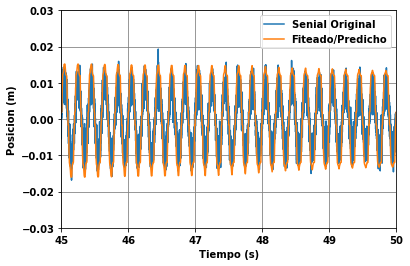

In [73]:
#plt.figure(figsize=(20,15))
#plt.plot(t_data[0:N_train+k+1],y_data[0:N_train+k+1], label = 'Usado para entrenar')
#plt.plot(t_data, y_sr, label='Sin ruido')
plt.plot(t_data,y_data, label = 'Senial Original')
plt.plot(t_data[N_train+k:], predicciones,label='Fiteado/Predicho')
plt.xlim([45, 50])
plt.ylim([-0.03, 0.03])
plt.grid(color = 'gray')
plt.legend()
plt.xlabel('Tiempo (s)', fontdict = font)
plt.ylabel('Posicion (m)', fontdict = font)

plt.savefig('OAA_senial_y_predicho_zoom', dpi = 400)
plt.show()

In [ ]:
len(predicciones)

### Cambiando el modelo y los datos

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(t_data,y_data)
plt.plot(t_data,y_sr, '--', lw = 4, label = 'Senial sin ruido')
plt.grid()
plt.legend()
plt.show()

In [ ]:
params, params_covariance = optimize.curve_fit(funcArmonica, t_data[0:2*n_periodo], y_data[0:2*n_periodo], bounds=(1, [5, 10]))
print(params)
print(params_covariance)

In [ ]:
plt.plot(t_data[0:N//2],y_data[0:N//2], label = 'Usado para fitear')
plt.plot(t_data, y_sr,label='Sin ruido')
plt.plot(t_data, funcArmonica(t_data, params[0], params[1]),label='Fiteado/Predicho')

plt.xlim([0, 2])
plt.legend(loc='best')
plt.show()

In [ ]:
error = np.sqrt(np.sum((funcArmonica(t_data, params[0], params[1]) - y_sr)**2))
print(error)

### Modelo RF

In [ ]:
k = n_periodo
x_nueva_forma = np.zeros((N - k,k))
y_nueva_forma = np.zeros(N - k)

In [ ]:
for i in range(x_nueva_forma.shape[0]):
    x_nueva_forma[i,:] = y_data[i:i+k]
    y_nueva_forma[i] = y_data[i+k]

In [ ]:
x_nueva_forma.shape, y_nueva_forma.shape

In [ ]:
N_train = 5000
x_train = x_nueva_forma[:N_train,:]
y_train = y_nueva_forma[:N_train]

In [ ]:
x_train.shape

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10).fit(x_train,y_train)

In [ ]:
y_pred = rf.predict(x_nueva_forma)

In [ ]:
y_pred.shape

In [ ]:
plt.plot(t_data[0:N_train],y_data[0:N_train], label = 'Usado para entrenar')
plt.plot(t_data, y_sr, label='Sin ruido')
plt.plot(t_data[k:], y_pred,label='Fiteado/Predicho')

plt.legend(loc='best')
plt.show()

### Estimar segunda mitad sin mirar

In [ ]:
cantidad_estimaciones = N - N_train
predicciones = []
for i in range(cantidad_estimaciones):
    if i == 0:
        x_prediccion = y_data[N//2 - k + 1 + i : N//2 + 1 + i]
        #print(x_prediccion.shape)
        y_pred_fecha = rf.predict(x_prediccion.reshape(1,-1))
        #print(y_pred_fecha)
        predicciones.append(y_pred_fecha)
    else:
        x_prediccion = np.append(x_prediccion, predicciones[-1])
        #print(x_prediccion)
        #print(x_prediccion.shape)
        y_pred_fecha = rf.predict(x_prediccion[i:].reshape(1,-1))
        #print(y_pred_fecha)
        predicciones.append(y_pred_fecha)

    

In [ ]:
plt.plot(t_data[0:N//2],y_data[0:N//2], label = 'Usado para fitear')
plt.plot(t_data, y_sr, label='Sin ruido')
plt.plot(t_data[N - cantidad_estimaciones:], predicciones,label='Fiteado/Predicho')

plt.legend(loc='best')
plt.show()